In [1]:
import ta
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import matplotlib.pylab as pylab

In [2]:
pylab.rcParams['figure.figsize'] = 18, 8 # Definimos el tamaño de los gráficos para que se ajusten bien al notebook
plt.style.use('bmh')

In [3]:
fast_SMA = 9
slow_SMA = 30
aapl = yf.download('AAPL', '2020-1-1','2020-10-25')

[*********************100%***********************]  1 of 1 completed


In [4]:
# Calcular las medias móviles
periods = [fast_SMA, slow_SMA]

# Ojo porque la última versión de la librería ta define todos los indicadores como clases.
# El valor numérico del indicador se puede obtener invocando el método correspondiente para esa clase.
# En nuestro caso obtenemos el valor de la media móvil simple llamando al método sma_indicator()
for p in periods:
    aapl[f'SMA_{p}'] = ta.trend.SMAIndicator(aapl.Close, p).sma_indicator()
aapl.dropna(inplace = True)
# Para saber exactamente qué metodos y atributos tiene definida la clase, para saber qué debes invocar, puedes teclear
# lo que tienes en la siguiente línea, que he descomentado.
# dir(ta.trend.SMAIndicator(aapl.Close, p))

# Detectar los cruces
#     Primero me calculo la diferencia entre las medias móviles
aapl['difference'] = aapl[f'SMA_{fast_SMA}'] - aapl[f'SMA_{slow_SMA}']
#     Ahora detecto los pasos por cero de esta diferencia: lo hago multiplicando dos valores consecutivos de la misma
#     y calculando qué signo tiene el producto, cuando dé negativo tendré un paso por cero.
#     Con esta información construyo una máscara booleana que devuelve True cuando el signo del producto
#     antemencionado es negativo. Finalmente le pido que me guarde los True como un entero, para poder operar luego.
aapl['sign_change'] = (np.sign(np.multiply(aapl.difference, aapl.difference.shift(1))) < 0).astype('int')
#     Como la columna que me indica el cambio de signo no me dice en qué sentido ocurren los cruces,
#     me construyo una columna 'signals' como el producto del vector de diferencias de las medias y el cambio de signo.
#     Así, tendré una señal positiva cuando la diferencia en el instante posterior al cruce sea positiva, esto es,
#     que tras el cruce, la media rápida está por encima de media lenta, por lo que habrá habido un cruce alcista
#     en el que la media rápida cruza al alza a la media lenta, constituyendo así una señal de compra. Para las señales
#     de venta se razona al revés.
aapl['signals'] = np.multiply(aapl.difference, aapl.sign_change)
#     Ya tengo en la columna signals valores positivos para las señales de compra y negativos para los de venta, los separo.
aapl['long_signal'] = np.where(aapl.signals > 0, 1, 0)
aapl['short_signal'] = np.where(aapl.signals < 0, 1, 0)

C:\Users\iorqu\anaconda3\lib\site-packages\pandas\core\series.py:679: RuntimeWarning: invalid value encountered in sign
  result = getattr(ufunc, method)(*inputs, **kwargs)


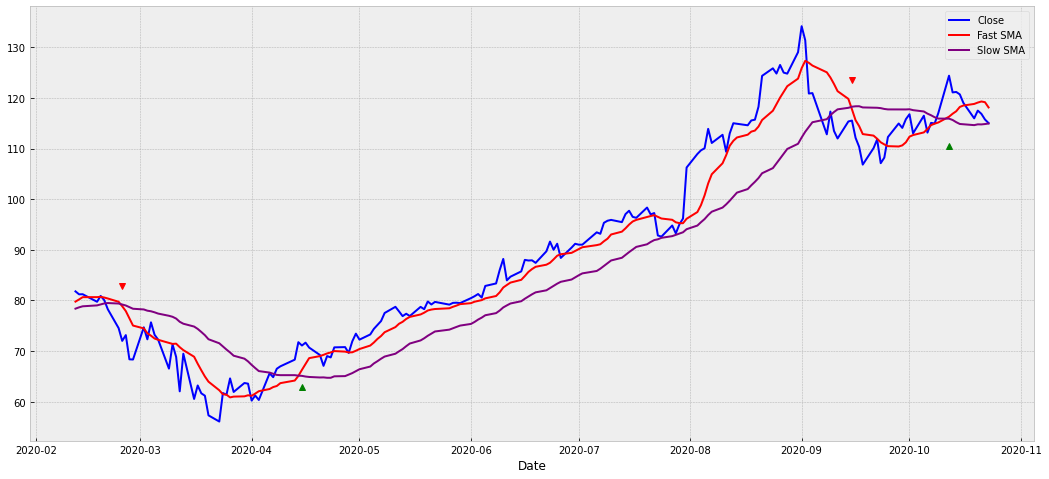

In [5]:
# Ahora procedo a graficar como se pide en el enunciado. Lo hago de manera individual con plt.plot
plt.plot(aapl.Close, label = 'Close', color = 'b')
plt.plot(aapl.SMA_9, label = 'Fast SMA', color = 'r')
plt.plot(aapl.SMA_30, label = 'Slow SMA', color = 'purple')
plt.plot(np.multiply(aapl[aapl['long_signal']>0].long_signal,0.95*aapl.SMA_9), marker = '^', color = 'g')
plt.plot(np.multiply(aapl[aapl['short_signal']>0].short_signal,1.05*aapl.SMA_9), marker = 'v', color = 'r')
plt.xlabel('Date')
plt.legend()

In [6]:
# Ahora voy a hacer una pequeña contribución para añadir algo más de interés a esta solución

# Mi objetivo es calcularme los retornos de una supuesta estrategia que se mantuviera 100% del tiempo en el mercado
# con posiciones largas mientras la media rápida está por encima de la lenta (tendencia alcista) y con cortas al revés.
# Así que me calculo una columna 'Position' que vale 1 cuando estoy largo y -1 si estoy corto. Esto me permitirá
# luego calcular los retornos de la estrategia de forma vectorial de manera sencilla.
# Nótese que en la definición de la posición, introduzco un retraso de un periodo con shift(1), esto es, no cambio mi 
# posición cuando me aparece la señal, sino en la vela siguiente, pues la señal me aparece con el cierre de la vela que me
# está dando la propia señal, por lo que yo utilizo esa información en la vela siguiente a la señal.
aapl['Position'] = np.where(aapl.dropna().difference.shift(1) > 0, 1, -1)
aapl['Returns'] = aapl.Close.diff(1)
aapl['Returns_strat'] = np.multiply(aapl.Returns, aapl.Position)

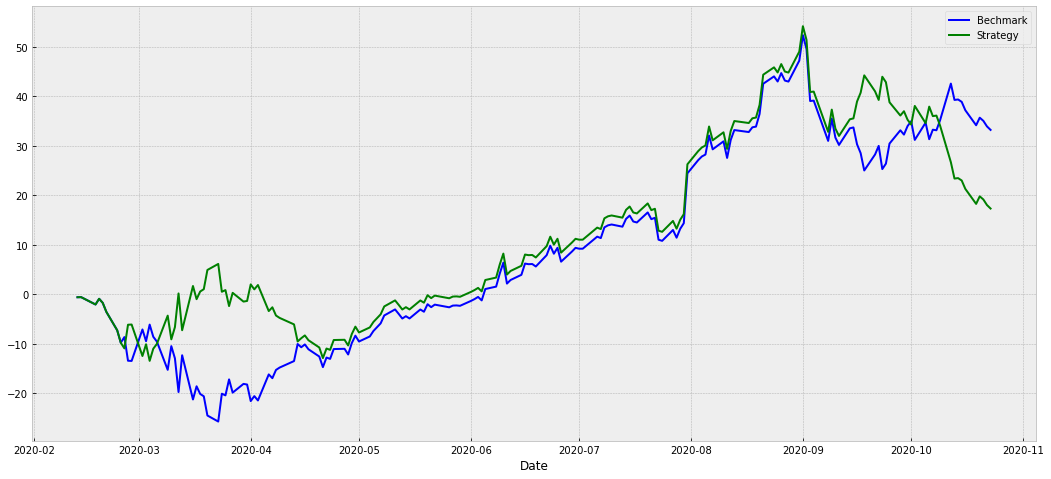

In [7]:
# Ahora dibujo los retornos acumulados que habría tenido si hubiera hecho un buy and hold del activo,
# y le voy a poner el nombre de benchmark, y encima, me dibujo los retornos acumulados de mi estrategia.
# Esta comparación visual me puede dar de un golpe de vista la utilidad de la estrategia frente a un buy and hold.
plt.plot(aapl.Returns.cumsum(), label = 'Bechmark', color = 'b')
plt.plot(aapl.Returns_strat.cumsum(), label = 'Strategy', color = 'g')
plt.xlabel('Date')
plt.legend()